In [2]:
# importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense , BatchNormalization , LeakyReLU , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, accuracy_score ,recall_score, f1_score


In [3]:
dtypes = {
"duration": np.int8,
"protocol_type": np.object,
"service": np.object,
"flag": np.object,
"src_bytes":  np.int8,
"dst_bytes":  np.int8,
"land": np.int8,
"wrong_fragment":  np.int8,
"urgent": np.int8,
"hot": np.int8,
"m_failed_logins":  np.int8,
"logged_in":  np.int8,
"num_compromised":  np.int8,
"root_shell":  np.int8,
"su_attempted":  np.int8,
"num_root": np.int8,
"num_file_creations":  np.int8,
"num_shells":  np.int8,
"num_access_files":  np.int8,
"num_outbound_cmds":  np.int8,
"is_host_login":  np.int8,
"is_guest_login":  np.int8,
"count": np.int8,
"srv_count":  np.int8,
"serror_rate": np.float16,
"srv_serror_rate": np.float16,
"rerror_rate": np.float16,
"srv_rerror_rate": np.float16,
"same_srv_rate": np.float16,
"diff_srv_rate": np.float16,
"srv_diff_host_rate": np.float16,
"dst_host_count":  np.int8,
"dst_host_srv_count":  np.int8,
"dst_host_same_srv_rate": np.float16,
"dst_host_diff_srv_rate": np.float16,
"dst_host_same_src_port_rate": np.float16,
"dst_host_srv_diff_host_rate": np.float16,
"dst_host_serror_rate": np.float16,
"dst_host_srv_serror_rate": np.float16,
"dst_host_rerror_rate": np.float16,
"dst_host_srv_rerror_rate": np.float16,
"label": np.object
}

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","m_failed_logins",
"logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
"num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
"same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
"dst_host_srv_rerror_rate","label"]

data = pd.read_csv("kddcup.data_10_percent_corrected", sep=",", names=columns, dtype=dtypes, index_col=None)

C:\Users\MMM\AppData\Local\Temp\ipykernel_94008\1119345328.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "protocol_type": np.object,
C:\Users\MMM\AppData\Local\Temp\ipykernel_94008\1119345328.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "service": np.object,
C:\Users\MMM\AppData\Local\Temp\ipykernel_94008\1119345328.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this w

In [4]:
data.label.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: label, dtype: int64

In [5]:
#Feature Selection
important_feature=['dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate','label']

In [6]:
# 0 for normal data and 1 for abnormalities
data.label=data.label.apply(lambda x: 0 if x == 'normal.' else 1)

In [7]:
data=data[important_feature]

In [8]:
#label encoding 
for column in data.columns:
    if data[column].dtype == np.object:
        encoded = LabelEncoder()
        
        encoded.fit(data[column])
        data[column] = encoded.transform(data[column])

C:\Users\MMM\AppData\Local\Temp\ipykernel_94008\492341383.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data[column].dtype == np.object:


In [10]:
#randomly sample 1000 data point for training
df_train=data[data.label==0].sample(1000)

In [11]:
#remove the item sampled from our dataset
index_list=df_train.index
data=data.drop(index_list)

In [12]:
#drop the label columns
df_train=df_train.drop('label',axis=1)

In [13]:
df_train.shape

(1000, 8)

In [14]:
def build_generator():
    model = Sequential()
    model.add(Dense(16, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(16))
    assert model.output_shape == (None,16 ) # Note: None is the batch size
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Dense(8 , activation="softmax"))
    assert model.output_shape == (None,8 )

    return model

In [15]:
def build_discriminator():
    model = tensorflow.keras.Sequential()
    model.add(Dense(16, use_bias=False,input_shape=[1,8]))
   
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(32, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(1 , activation='sigmoid'))

    return model

In [16]:
generator=build_generator()
discriminator=build_discriminator()

In [17]:
cross_entropy = BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
bce = BinaryCrossentropy()
loss = bce([1., 1., 1., 1.], [1., 1., 1., 1.])
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  -0.0


In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [22]:
EPOCHS = 50
noise_dim = 100
#num_examples_to_generate = 16
BATCH_SIZE = 64



In [23]:
@tf.function
def train_step(inputs):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    inputs=tf.reshape(inputs,(1,8))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_inputs = generator(noise)

        real_output = discriminator(inputs)
        fake_output = discriminator(generated_inputs)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
     
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    g = tf.cast(gen_loss, tf.float32)
    d = tf.cast(disc_loss, tf.float32)
    return (g,d)

In [26]:
history=dict()
history['gen']=[]
history['dis']=[]
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            b = tf.cast(batch, tf.float32)
            gen_loss,dis_loss= train_step(b)
            history['gen'].append(gen_loss)
            history['dis'].append(dis_loss)
        print ('Time for epoch {} is {} sec '.format(epoch + 1, time.time()-start))

In [27]:
x_train=df_train.values
train(x_train,EPOCHS) 

Time for epoch 1 is 13.265489101409912 sec 
Time for epoch 2 is 13.483121156692505 sec 
Time for epoch 3 is 13.254946231842041 sec 
Time for epoch 4 is 11.239826679229736 sec 
Time for epoch 5 is 11.57972764968872 sec 
Time for epoch 6 is 12.391696691513062 sec 
Time for epoch 7 is 11.963348388671875 sec 
Time for epoch 8 is 12.347578525543213 sec 
Time for epoch 9 is 11.006589412689209 sec 
Time for epoch 10 is 10.657093048095703 sec 
Time for epoch 11 is 11.009340763092041 sec 
Time for epoch 12 is 11.30051875114441 sec 
Time for epoch 13 is 12.016072511672974 sec 
Time for epoch 14 is 11.645524978637695 sec 
Time for epoch 15 is 12.392716407775879 sec 
Time for epoch 16 is 12.955224990844727 sec 
Time for epoch 17 is 12.64058232307434 sec 
Time for epoch 18 is 12.562633752822876 sec 
Time for epoch 19 is 13.657177686691284 sec 
Time for epoch 20 is 13.694513320922852 sec 
Time for epoch 21 is 13.653598308563232 sec 
Time for epoch 22 is 13.830554962158203 sec 
Time for epoch 23 is 1

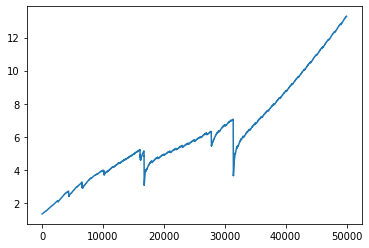

In [28]:
plt.plot(history['gen'])

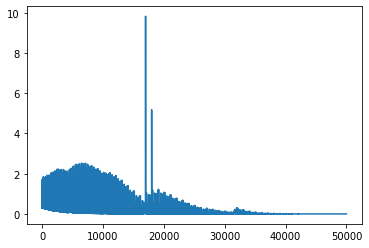

In [29]:
plt.plot(history['dis'])

In [30]:
y_test=data.label
x_test=data.drop('label',axis=1).values.reshape(-1,1,8)

In [31]:
y_pred=discriminator.predict(x_test)

Text(0, 0.5, 'y_pred')

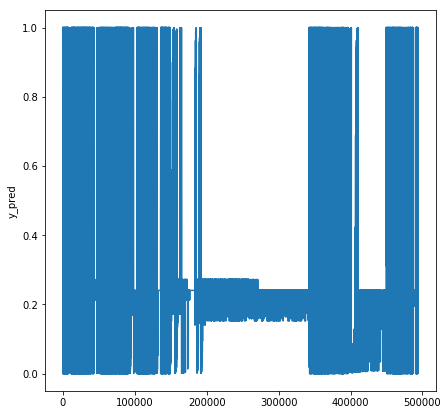

In [29]:
#range of output value
plt.figure(figsize=(7,7))
plt.plot(range(len(y_pred)),y_pred.reshape(-1,1))
plt.ylabel('y_pred')

In [32]:
#looking for the optimal probability threshold
prob=[0.5,0.55,0.6,0.65,0.75,0.8,0.85,0.9,0.95,1,2,2.5,5]
for p in prob:
    pred_value =[1 if i<p   else 0 for i in y_pred]
    f1=f1_score(y_test,pred_value)
    acc=accuracy_score(y_test,pred_value)
    precision=average_precision_score(y_test,pred_value)
    recall= recall_score(y_test,pred_value)
    print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
    print(pred_value.count(0),pred_value.count(1))

prob =0.5 and f1 score =0.7968424770818837 : accuracy=0.7281880487849401 : precision=0.9338830129540395 : recall=0.662421265151496
230133 262888
prob =0.55 and f1 score =0.7968614277290071 : accuracy=0.7282002186519438 : precision=0.9338596189877397 : recall=0.662469155095364
230101 262920
prob =0.6 and f1 score =0.7968505560339078 : accuracy=0.7281819638514384 : precision=0.9338369505811706 : recall=0.662469155095364
230092 262929
prob =0.65 and f1 score =0.7969599776879096 : accuracy=0.7283036625214747 : precision=0.9338664832913869 : recall=0.6626203864970522
230032 262989
prob =0.75 and f1 score =0.7970712026347658 : accuracy=0.7284273895026784 : precision=0.93389650821345 : recall=0.662774138422102
229971 263050
prob =0.8 and f1 score =0.7970748490061308 : accuracy=0.728431446125013 : precision=0.9338974926371244 : recall=0.6627791794688249
229969 263052
prob =0.85 and f1 score =0.7971830217502001 : accuracy=0.728551116483882 : precision=0.9339245067299873 : recall=0.6629304108705